<a href="https://colab.research.google.com/github/tomiambro/ap_automatico/blob/tps-tomi/tp2pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, tensor, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
root_path = 'gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset'  #change dir to your project folder

In [5]:
from pathlib import Path
imgs_path = Path(f'{root_path}/images/Images')
imgs_path.relative_to(root_path)

PosixPath('images/Images')

In [6]:
classes_path = [c for c in imgs_path.iterdir() if c.is_dir()]
classes_names = [str(c.stem).lower().split('-')[1] for c in classes_path]
classes_names[:5]

['chihuahua', 'maltese_dog', 'japanese_spaniel', 'pekinese', 'shih']

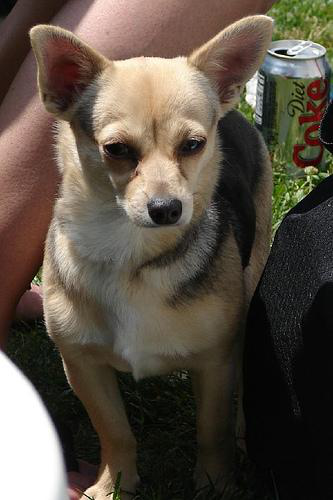

In [7]:
chihuahuas = [img for img in classes_path[0].iterdir()]
Image.open(chihuahuas[0])

In [8]:
labels = [str(c.stem) for c in sorted(imgs_path.glob('*'))]
f = sorted(imgs_path.glob('*/*'))
le = preprocessing.LabelEncoder()
le.fit(labels)
label = str(f[200].parents[0].stem).split('/')[-1]
tensor(le.transform([label]))

tensor([1])

In [9]:
# imgs = [read_image(str(img)).to(device) for img in f]

In [10]:
# for i, img in enumerate(imgs):
#  if img.shape[0] == 4:
#    print(img.shape)
#    print('La encontre!', i)
#    print(f'Eliminando: {f[i]}')
#    f[i].unlink()

In [11]:
class CustomImageDataset(Dataset):
  def __init__(self, imgs_dir, transform=None):
    self.imgs_dir = Path(imgs_dir)
    self.transform = transform
    self.f = sorted(imgs_path.glob('*/*'))
    self.labels = [str(c.stem) for c in sorted(imgs_path.glob('*'))]
    le = preprocessing.LabelEncoder()
    le.fit(self.labels)

  def __len__(self):
    return len(self.f)

  def __getitem__(self, idx):
    image = read_image(str(self.f[idx]))
    label = str(self.f[idx].parents[0].stem).split('/')[-1]
    if self.transform:
      image = self.transform(image)
    return image, int(le.transform([label]))

In [12]:
t = transforms.Compose([
    # transforms.Resize((img_size, img_size))
    transforms.CenterCrop(256),
    # transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

data = CustomImageDataset(f'{root_path}/images/Images', transform=t)

In [13]:
from torch.utils.data import random_split

train, test = random_split(data, [round(len(data)*.6), round(len(data)*.4)], generator=torch.Generator().manual_seed(42))

In [14]:
train_dataloader = DataLoader(train, batch_size=128, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test, batch_size=128, shuffle=False, num_workers=2)

In [15]:
train_features, train_labels = next(iter(train_dataloader))

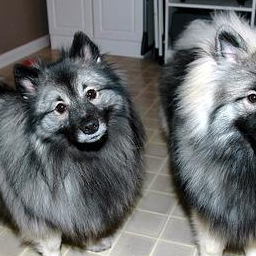

In [16]:
trans = transforms.ToPILImage()
trans(train_features[0])

In [17]:
print(f"Label: {train_labels[0]}")

Label: 109


In [18]:
size = 180
n_classes = 120

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # ([64, 3, 180, 180])
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 252
        self.pool = nn.MaxPool2d(2, 2)
        # ho, wo = 126
        # ([64, 6, 88, 88])
        self.conv2 = nn.Conv2d(6, 16, 5)
        # ho, wo = 122
        # ho, wo = 61
        # ([64, 16, 42, 42])
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=120, bias=True)
)

In [19]:
params = [p for p in model.parameters() if p.requires_grad]
loss_f = nn.CrossEntropyLoss()
optimizer = optim.SGD(params, lr=0.01, momentum=0.9)
optimizer.zero_grad()

In [20]:
def batch_accuracy(output, yb):
    preds = xb.sigmoid()
    print(preds.shape, yb.shape)
    _, predicted = torch.max(preds.data, 1)
    # torch.Size([128, 120]) torch.Size([128])
    correct = (predicted>0.5) == yb
    # acc = accuracy_score(yb, preds.detach().numpy())
    return correct.float().mean()

In [21]:
def accuracy(outputs, y):
  _, predicted = torch.max(outputs.data, 1)
  # total += y.size(0)
  correct = (predicted == y).sum().item()
  return tensor(correct / y.shape[0])

In [22]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_f(preds, yb)
    loss.backward()

In [23]:
def train_epoch(model, dl):
    for xb,yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        calc_grad(xb, yb, model)
        optimizer.step()
        optimizer.zero_grad()

In [24]:
def validate_epoch(model, test_dl):
    accs = [accuracy(model(xb.to(device)), yb.to(device)) for xb,yb in test_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [25]:
def train_model(model, epochs, dl, test_dl):
    for i in range(epochs):
        train_epoch(model, dl)
        print(f'Accuracy: {validate_epoch(model, test_dl)}', end=' ')

In [26]:
train_model(model, 3, train_dataloader, test_dataloader)

Accuracy: 0.0126 Accuracy: 0.0188 Accuracy: 0.0228 